In [1]:
import torch
import torch_geometric
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import MyData as data
from torch_geometric.loader import DataLoader
from matplotlib.lines import Line2D
import ROOT
import numpy as np

Welcome to JupyROOT 6.20/02


In [2]:
view='yz'

In [3]:
NUM_FEATURES = 5
print(NUM_FEATURES)
NUM_CLASSES =1
HIDDEN_LAYER_SIZE = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class SageConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Model layers
        self.conv1 = SAGEConv(NUM_FEATURES, HIDDEN_LAYER_SIZE)
        self.conv2 = SAGEConv(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE-64)
        self.conv3 = SAGEConv(HIDDEN_LAYER_SIZE-64, NUM_CLASSES)
        #self.lin_1 = Linear(HIDDEN_LAYER_SIZE, NUM_CLASSES*4)
        #self.lin_2 = Linear(NUM_CLASSES*4, NUM_CLASSES)

    def forward(self, data):
        # The architecture itself
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
       
        #x = self.lin_1(x)
       # x = F.tanh(x)
        #x = self.lin_2(x)
        return F.sigmoid(x)
if view=='xz':
    best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/1millionevt_sageconv_200epoch/best_model_sageconv4.pkl")
else:
     best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/1millionevt_sageconv_200epoch/best_model_sageconv_yz_4.pkl")
best_model.to(device) 

5


SageConv(
  (conv1): SAGEConv(5, 256, aggr=mean)
  (conv2): SAGEConv(256, 192, aggr=mean)
  (conv3): SAGEConv(192, 1, aggr=mean)
)

In [4]:
data=data.dataset_preparation(root='/lustrehome/federicacuna/TestBeam_T10_2023/Data/')
if view=='xz':
    fname='pi-_10GeV_4ly_exp'
else:
    fname='pi-_10GeV_4ly_1e-4_yz'

In [5]:
data_trk=data.get(0,fname)

taking the  data_0.pt


In [6]:
len(data_trk)

108860

In [19]:
for i in range(10):
    print(i,' ',data_trk[i])

0   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
1   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
2   Data(x=[8, 5], edge_index=[2, 15], edge_attr=[15, 2])
3   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
4   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
5   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
6   Data(x=[8, 5], edge_index=[2, 15], edge_attr=[15, 2])
7   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
8   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])
9   Data(x=[6, 5], edge_index=[2, 8], edge_attr=[8, 2])


In [9]:
# for data in test_loader:
#     # print(data)
#     data.to(device)
#     model_output = best_model(data)
#     best_model.to(device)
#     predicted_class = torch.where(model_output > threshold, 1, 0)

217   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 2])
tensor([[1.0000],
        [0.1517],
        [0.1435],
        [0.7974],
        [0.0071],
        [0.8268],
        [0.8529]], device='cuda:0', grad_fn=<SigmoidBackward0>)


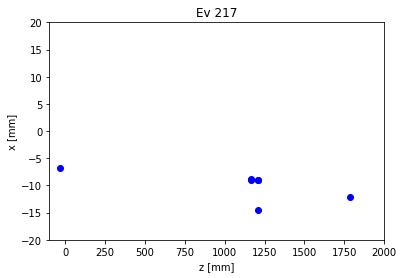

In [7]:
best_model.eval()
ev_id=217
test_batch=data_trk[ev_id]
print(ev_id,' ',test_batch)
nly=4
test_batch.to(device) 
model_output = best_model(test_batch) 
model_output.to(device)
predicted_class = torch.where(model_output > 0.7, 1, 0)

print(model_output)

test_batch=test_batch.detach().cpu()
if view=='xz':
    ly=test_batch.x[:,2]
    x=test_batch.x[:,0]
    z=test_batch.x[:,3]
    label=test_batch.y
    label_pred=predicted_class

    for i in range(len(x)):
            plt.scatter(z[i],x[i], color='blue', label='1')
    plt.xlim(-100,2000)
    plt.ylim(-20,20)
    plt.xlabel('z [mm]')
    plt.ylabel('x [mm]')
    plt.title(f'Ev {ev_id}')
else:
    ly=test_batch.x[:,2]
    y=test_batch.x[:,0]
    z=test_batch.x[:,3]
    label=test_batch.y
    label_pred=predicted_class

    for i in range(len(y)):
            plt.scatter(z[i],y[i], color='blue', label='1')
    plt.xlim(-100,2000)
    plt.ylim(-20,20)
    plt.xlabel('z [mm]')
    plt.ylabel('y [mm]')
    plt.title(f'Ev {ev_id}')



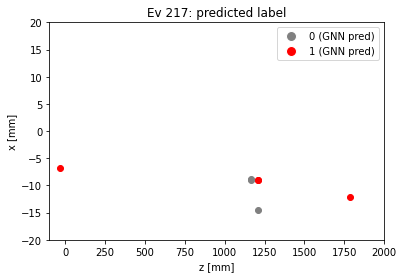

In [8]:
if view=='xz':
    x_pred=[]
    ly_pred=[]
    z_pred=[]
    for i in range(len(x)):
        if label_pred[i] == 0:
            plt.scatter(z[i],x[i], color='grey', label='0 (Pred)')
        else:
            x_pred.append(x[i].item())
            ly_pred.append(ly[i].item())
            z_pred.append(z[i].item())
            plt.scatter(z[i],x[i], color='red', label='1 (Pred)')

    plt.xlim(-100,2000)
    plt.ylim(-20,20)
    #plt.legend()
    plt.ylabel('x [mm]')
    plt.xlabel('z [mm]')
    plt.title(f'Ev {ev_id}: predicted label')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 (GNN pred)', markerfacecolor='grey', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='1 (GNN pred)', markerfacecolor='red', markersize=10)]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/gnn_results_expdata/1million_sage_conv/pred_label_evxz{ev_id}')
else:
    y_pred=[]
    ly_pred=[]
    z_pred=[]
    for i in range(len(y)):
        if label_pred[i] == 0:
            plt.scatter(z[i],y[i], color='grey', label='0 (Pred)')
        else:
            y_pred.append(y[i].item())
            ly_pred.append(ly[i].item())
            z_pred.append(z[i].item())
            plt.scatter(z[i],y[i], color='red', label='1 (Pred)')

    plt.xlim(-100,2000)
    plt.ylim(-20,20)
    #plt.legend()
    plt.ylabel('y [mm]')
    plt.xlabel('z [mm]')
    plt.title(f'Ev {ev_id}: predicted label')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 (GNN pred)', markerfacecolor='grey', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='1 (GNN pred)', markerfacecolor='red', markersize=10)]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/gnn_results_expdata/1million_sage_conv/pred_label_evyz{ev_id}')

In [7]:
if view=='xz':
    myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_exp_data_xview.root','RECREATE')

    test_batch_ev=[]
    for ev_id in range(0,len(data_trk)):
        test_batch_ev.append(data_trk[ev_id])
    
    predicted_class_ev=[]
    for i in test_batch_ev:
        i.to(device)
        model_output = best_model(i) 

        predicted_class_ev.append((torch.where(model_output > 0.7, 1, 0)))

    ly_ev=[]
    x_ev=[]
    z_ev=[]
    pe_ev=[]
    dx_ev=[]
    no_good_ev=[]
    for i in range(len(test_batch_ev)):    
        ev=test_batch_ev[i]
        ev=ev.detach().cpu()
        label = predicted_class_ev[i].detach().cpu().numpy()
        ly_ev.append([])
        x_ev.append([])
        z_ev.append([])
        pe_ev.append([])
        dx_ev.append([])
        if all(el==0 for el in label):
            print(i)
            no_good_ev.append(i)
        for j,lab in enumerate(label):
            # print(j)
            # print(lab)
            if lab==1:
                tmp_ly=ev.x[j,2].detach().cpu().tolist()
                tmp_x=ev.x[j,0].detach().cpu().tolist()
                tmp_z=ev.x[j,3].detach().cpu().tolist() 
                tmp_dx=ev.x[j,1].detach().cpu().tolist() 
                tmp_pe=ev.x[j,4].detach().cpu().tolist()
                # print(tmp_x)
                ly_ev[i].append(tmp_ly)
                x_ev[i].append(tmp_x)
                z_ev[i].append(tmp_z)
                dx_ev[i].append(tmp_dx)
                pe_ev[i].append(tmp_pe)


    OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
    ly_ev_vec = ROOT.std.vector("float")()
    x_ev_vec = ROOT.std.vector("float")()
    z_ev_vec = ROOT.std.vector("float")()
    dx_ev_vec = ROOT.std.vector("float")()
    pe_ev_vec = ROOT.std.vector("float")()
    no_good_ev_vec=ROOT.std.vector("int")()
    OutTree.Branch("ly_ev_vec", ly_ev_vec)
    OutTree.Branch("x_ev_vec", x_ev_vec)
    OutTree.Branch("z_ev_vec", z_ev_vec)
    OutTree.Branch("dx_ev_vec", dx_ev_vec)
    OutTree.Branch("pe_ev_vec", pe_ev_vec)
    # print(x_ev)
    
    OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
    # print(x_ev)
    
    for no_good in no_good_ev:
        no_good_ev_vec.push_back(no_good)

    for l,x,z,dx,pe in zip(ly_ev,x_ev,z_ev,dx_ev,pe_ev):

        # Clear the contents of the vector
        ly_ev_vec.clear()
        x_ev_vec.clear()
        z_ev_vec.clear()
        dx_ev_vec.clear()
        pe_ev_vec.clear()

        # Replace the contents in the vector with the contents
        # from the current array
        ly_ev_vec.reserve(len(l))
        x_ev_vec.reserve(len(x))
        z_ev_vec.reserve(len(z))
        dx_ev_vec.reserve(len(dx))
        pe_ev_vec.reserve(len(pe))


        for il in l:
            ly_ev_vec.push_back(il)
        for ix in x:
            x_ev_vec.push_back(ix)
        for iz in z:
            z_ev_vec.push_back(iz)
        for idx in dx:
            dx_ev_vec.push_back(idx)
        for ipe in pe:
            pe_ev_vec.push_back(ipe)


        OutTree.Fill()

    OutTree.Write()
    myfile.Close()
else:
    myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_exp_data_yview.root','RECREATE')

    test_batch_ev=[]
    for ev_id in range(0,len(data_trk)):
        test_batch_ev.append(data_trk[ev_id])
        predicted_class_ev=[]

    for i in test_batch_ev:
        i.to(device)
        model_output = best_model(i) 

        predicted_class_ev.append((torch.where(model_output > 0.7, 1, 0)))


    ly_ev=[]
    y_ev=[]
    z_ev=[]
    pe_ev=[]
    dy_ev=[]
    no_good_ev=[]
    for i in range(len(test_batch_ev)):    
        ev=test_batch_ev[i]
        ev=ev.detach().cpu()
        label = predicted_class_ev[i].detach().cpu().numpy()
        ly_ev.append([])
        y_ev.append([])
        z_ev.append([])
        pe_ev.append([])
        dy_ev.append([])
        if all(el==0 for el in label):
            # print(i)
            no_good_ev.append(i)
        for j,lab in enumerate(label):
            # print(j)
            # print(lab)
            if lab==1:
                tmp_ly=ev.x[j,2].detach().cpu().tolist()
                tmp_y=ev.x[j,0].detach().cpu().tolist()
                tmp_z=ev.x[j,3].detach().cpu().tolist() 
                tmp_dy=ev.x[j,1].detach().cpu().tolist() 
                tmp_pe=ev.x[j,4].detach().cpu().tolist()
                # print(tmp_x)
                ly_ev[i].append(tmp_ly)
                y_ev[i].append(tmp_y)
                z_ev[i].append(tmp_z)
                dy_ev[i].append(tmp_dy)
                pe_ev[i].append(tmp_pe)


    OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
    ly_ev_vec = ROOT.std.vector("float")()
    y_ev_vec = ROOT.std.vector("float")()
    z_ev_vec = ROOT.std.vector("float")()
    dy_ev_vec = ROOT.std.vector("float")()
    pe_ev_vec = ROOT.std.vector("float")()
    no_good_ev_vec=ROOT.std.vector("int")()
    
    OutTree.Branch("ly_ev_vec", ly_ev_vec)
    OutTree.Branch("y_ev_vec", y_ev_vec)
    OutTree.Branch("z_ev_vec", z_ev_vec)
    OutTree.Branch("dy_ev_vec", dy_ev_vec)
    OutTree.Branch("pe_ev_vec", pe_ev_vec)
    OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
    # print(x_ev)
    
    for no_good in no_good_ev:
        no_good_ev_vec.push_back(no_good)
        
    for l,y,z,dy,pe in zip(ly_ev,y_ev,z_ev,dy_ev,pe_ev):

        # Clear the contents of the vector
        ly_ev_vec.clear()
        y_ev_vec.clear()
        z_ev_vec.clear()
        dy_ev_vec.clear()
        pe_ev_vec.clear()

        # Replace the contents in the vector with the contents
        # from the current array
        ly_ev_vec.reserve(len(l))
        y_ev_vec.reserve(len(y))
        z_ev_vec.reserve(len(z))
        dy_ev_vec.reserve(len(dy))
        pe_ev_vec.reserve(len(pe))
       

        for il in l:
            ly_ev_vec.push_back(il)
        for iy in y:
            y_ev_vec.push_back(iy)
        for iz in z:
            z_ev_vec.push_back(iz)
        for idy in dy:
            dy_ev_vec.push_back(idy)
        for ipe in pe:
            pe_ev_vec.push_back(ipe)


        OutTree.Fill()

    OutTree.Write()
    myfile.Close()
    